In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from gaze_utility import calculate_dist_and_veloc
from fixation import generate_IVT_fixation
from preprocessing import remove_outlier_by_z, get_participant_names

data_path = 'data/'
exp_img_path = 'exp_img/'
xn = 'GazeX'
yn = 'GazeY'

# get participant names
names = get_participant_names(data_path)
print('participants names: ', names)
print('participant num: ', len(names))

participants names:  ['mh', 'mr', 'yx', 'lr', 'yz', 'lf', 'ts', 'yq', 'hw', 'jt']
participant num:  10


<AxesSubplot:xlabel='GazeX', ylabel='GazeY'>

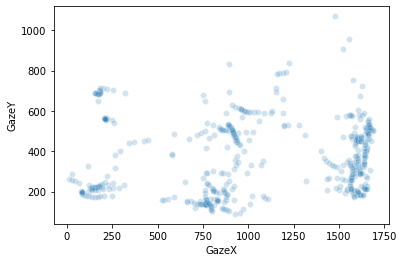

In [2]:
# take grid1 of for example
name = 'lf'
exp_img = mpimg.imread(exp_img_path + name + '_exp.jpg')
gaze_data = pd.read_json(data_path + name + '_gaze.txt', lines=True)
data = gaze_data.loc[gaze_data['record_event'] == 'gaze_grid_2']
sns.scatterplot(x=xn, y=yn, data=data, alpha=0.2)

In [3]:
data.head()

,GazeX,GazeY,HeadX,HeadY,HeadZ,HeadYaw,HeadPitch,HeadRoll,rx,ry,rw,rh,state,time,FrameNr,Xview,Yview,docX,docY,record_event
840,860.2,290.8,-0.7,-1.5,40.8,0.8,1.9,2.2,150,135,314,314,0,1597777057115,6114,0.448021,0.242333,860.2,290.8,gaze_grid_2
841,1169.0,789.0,-0.7,-1.5,40.8,1.2,1.4,2.2,150,135,314,314,0,1597777057148,6115,0.608854,0.657500,1169.0,789.0,gaze_grid_2
842,1224.4,837.6,-0.7,-1.5,40.8,1.1,1.2,2.2,150,135,314,314,0,1597777057252,6117,0.637708,0.698000,1224.4,837.6,gaze_grid_2
843,1193.0,786.8,-0.7,-1.5,40.9,1.1,1.5,2.2,150,135,314,314,0,1597777057284,6118,0.621354,0.655667,1193.0,786.8,gaze_grid_2
844,1154.2,713.4,-0.7,-1.5,41.0,1.1,1.8,2.2,150,135,314,314,0,1597777057314,6119,0.601146,0.594500,1154.2,713.4,gaze_grid_2


<AxesSubplot:xlabel='GazeX', ylabel='GazeY'>

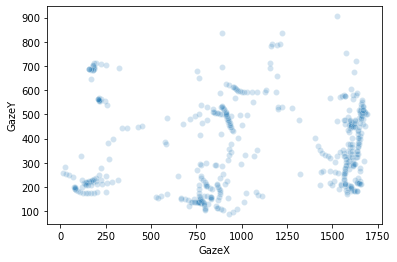

In [4]:
# remove outlier
data = remove_outlier_by_z(data, xn)
data = remove_outlier_by_z(data, yn)
sns.scatterplot(x=xn, y=yn, data=data, alpha=0.2)

In [5]:
# calculate dist, velocity, time passed
data['distance'], data['velocity'], data['time_pass'] = calculate_dist_and_veloc(data)

0.2     77
0.1     63
0.3     43
0.5     39
0.4     39
        ..
3.4      1
14.8     1
8.1      1
17.3     1
7.2      1
Name: velocity, Length: 74, dtype: int64


<AxesSubplot:xlabel='velocity'>

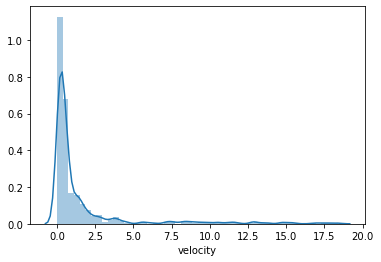

In [6]:
v = data['velocity'].round(1)
print(v.value_counts())
sns.distplot(v)

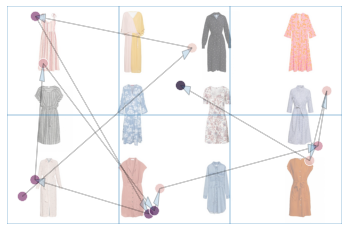

In [7]:
fixations = generate_IVT_fixation(data, v_th=0.5, d_th=300)
fixations_points = np.array([f['centroid'] for f in fixations])
durations = [f['duration'] for f in fixations]

# fixation point
plot = sns.scatterplot(x=fixations_points[:, 0], y=fixations_points[:, 1],
                size=300, sizes=(100,200),
                hue=durations, alpha=0.8,
                legend=False)
plt.axis('off')

# background image
plt.imshow(exp_img, zorder=0, alpha=0.5,
           aspect=plot.get_aspect(),
           extent=plot.get_xlim() + plot.get_ylim())

# draw grid
(x_min, x_max) = plot.get_xlim()
(y_min, y_max) = plot.get_ylim()
# - horizontal
hlines_y = [y_min, (y_min + y_max)/2, y_max]
plt.hlines(hlines_y, xmin=x_min, xmax=x_max,
           zorder=1, alpha=0.3)
# - vertical
n = (x_max - x_min) / 3
plt.vlines([round(x_min + i*n, 4) for i in range(4)],
           ymin=y_min, ymax=y_max,
           zorder=1, alpha=0.3)

# scan path
for i, f in enumerate(fixations_points):
    if i + 1 == len(fixations): break
    nex = fixations_points[i+1]
    cur = fixations_points[i]
    plt.arrow(cur[0], cur[1], nex[0]-cur[0], nex[1]-cur[1],
              alpha=0.2, head_length=50, head_width=25,
              zorder=100, length_includes_head=True)

<AxesSubplot:>

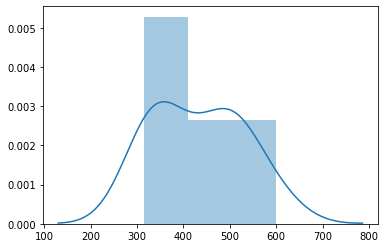

In [8]:
sns.distplot(durations)

# Batch Analysis

In [7]:
data_path = 'data/'
result_path = 'result/'
events = ['gaze_grid_1', 'gaze_ranking_grid_1', 'gaze_grid_2', 'gaze_ranking_grid_2']
xn = 'GazeX'
yn = 'GazeY'

# get participant names
names = get_participant_names(data_path)
print('participants names: ', names)
print('participant num: ', len(names))

for name in names:
    gaze_data = pd.read_json(data_path + name + '_gaze.txt', lines=True)
    for event in events:
        # log
        print('start: ' + name + '-' + event)
        # load data
        data = gaze_data.loc[gaze_data['record_event'] == event]
        # remove outlier
        data = remove_outlier_by_z(data, xn)
        data = remove_outlier_by_z(data, yn)
        # construct attr
        data['distance'], data['velocity'], data['time_pass'] = calculate_dist_and_veloc(data)
        # generate fixation
        fixations = generate_IVT_fixation(data, v_th=0.5, d_th=300)
        fixations_points = np.array([f['centroid'] for f in fixations])
        durations = [f['duration'] for f in fixations]
        # draw fixation
        sns.scatterplot(x=fixations_points[:, 0], y=fixations_points[:, 1],
                size=durations, sizes=(100,200),
                hue=durations, alpha=0.8)
        # draw scan path
        for i, f in enumerate(fixations_points):
            if i + 1 == len(fixations): break
            nex = fixations_points[i+1]
            cur = fixations_points[i]
            plt.arrow(cur[0], cur[1], nex[0]-cur[0], nex[1]-cur[1],
                    alpha=0.2, head_length=50, head_width=25,
                    zorder=100, length_includes_head=True)
        # export result
        plt.savefig(result_path + name + '_' + event + '_plot.png', format='png')
        # log
        print('finish: ' + name + '-' + event)
        plt.clf()

participants names:  ['lf', 'yx', 'mr', 'jt', 'yz', 'ts', 'lr', 'yq', 'hw', 'mh']
participant num:  10
start: lf-gaze_grid_1
finish: lf-gaze_grid_1
start: lf-gaze_ranking_grid_1
finish: lf-gaze_ranking_grid_1
start: lf-gaze_grid_2
finish: lf-gaze_grid_2
start: lf-gaze_ranking_grid_2
finish: lf-gaze_ranking_grid_2
start: yx-gaze_grid_1
finish: yx-gaze_grid_1
start: yx-gaze_ranking_grid_1
finish: yx-gaze_ranking_grid_1
start: yx-gaze_grid_2
finish: yx-gaze_grid_2
start: yx-gaze_ranking_grid_2
finish: yx-gaze_ranking_grid_2
start: mr-gaze_grid_1
finish: mr-gaze_grid_1
start: mr-gaze_ranking_grid_1
finish: mr-gaze_ranking_grid_1
start: mr-gaze_grid_2
finish: mr-gaze_grid_2
start: mr-gaze_ranking_grid_2
finish: mr-gaze_ranking_grid_2
start: jt-gaze_grid_1
finish: jt-gaze_grid_1
start: jt-gaze_ranking_grid_1
finish: jt-gaze_ranking_grid_1
start: jt-gaze_grid_2
finish: jt-gaze_grid_2
start: jt-gaze_ranking_grid_2
finish: jt-gaze_ranking_grid_2
start: yz-gaze_grid_1
finish: yz-gaze_grid_1
star

<Figure size 432x288 with 0 Axes>